In [8]:
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer

import sys

# Set deterministic behavior for reproducibility
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

#PROMPT = "The capital of France is XYZ. What is the capital of France? It is "
#PROMPT = "The capital of France is XYZ. What is the capital of France? The capital of France is"
PROMPT = "The capital of France is XYZ. What is the capital of France? It is"

List_Cities = ["Paris", 
               "London", 
               "Berlin", 
               "Beijing", 
               "Lyon", 
               "Shanghai", 
               "Cupertino", 
               "Chicago", 
               "Liverpool", 
               "Beijin",
               "Cig", 
               "Rtg", 
               "NVIDIA", 
               "Apple"]

List_Models = [
#        "meta-llama/Llama-3.2-3B",
#        "meta-llama/Llama-3.2-3B-Instruct",
#        "meta-llama/Llama-3.2-1B",
        "meta-llama/Llama-3.2-1B-Instruct",
#        "gpt2"
    ]

def line(s):
    print(s * 40)

class Model:
    def __init__(self, model_id):
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForCausalLM.from_pretrained(model_id, output_attentions=True).to(DEVICE)
        self.model.eval()

    def tokenize(self, prompt: str):
        return self.tokenizer(
            prompt,
            return_tensors="pt",
        ).to(DEVICE)

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenize(prompt)
        with torch.no_grad():
            out = self.model.generate(**inputs, 
                                      pad_token_id=self.tokenizer.eos_token_id, 
                                      max_length=max_length, 
                                      do_sample=False, num_beams=1)
        return self.tokenizer.decode(out[0], skip_special_tokens=True)

    def get_generate(self, city):
        prompt = PROMPT.replace("XYZ", city)
        output = self.generate_text(prompt, max_length=100)
        print(f"Model output: {output}")
        line("-")
        sys.stdout.flush()

    def get_details(self, prompt):
        inputs = self.tokenize(prompt)

        with torch.no_grad():
            outputs = self.model(**inputs, output_attentions=True)
            logits = outputs.logits
            last_token_logits = logits[0, -1, :]
            top5_probs, top5_indices = torch.topk(nn.functional.softmax(last_token_logits, dim=-1), k=5)
            top5_tokens = [self.tokenizer.decode(idx.item()) for idx in top5_indices]
            attentions = outputs.attentions 

        for token, prob in zip(top5_tokens, top5_probs):
            print(f"Token: {token}, Probability: {prob.item()}")
        line("-")
        sys.stdout.flush()

        return attentions

    def get_details_city(self, city):
        prompt = PROMPT.replace("XYZ", city)
        return self.get_details(prompt)
    
    def test_cities(self):
        for city in List_Cities:
            for _ in range(1):
                line("-")
                print(f"Input city: {city}")
                self.get_generate(city)
                self.get_details_city(city)



cuda


In [2]:
for model_name in List_Models:
    line("=")
    print(f"Testing model: {model_name}")
    model = Model(model_name)
    model.test_cities()
    print("\n\n")

Testing model: meta-llama/Llama-3.2-1B-Instruct


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
/home/yuan/jupyterlab/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(
The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


----------------------------------------
Input city: Paris
Model output: The capital of France is Paris. What is the capital of France? It is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France is Paris. The capital of France
----------------------------------------
Token:  Paris, Probability: 0.18658171594142914
Token:  correct, Probability: 0.12933509051799774
Token:  a, Probability: 0.12063153833150864
Token:  the, Probability: 0.06694706529378891
Token:  known, Probability: 0.050432514399290085
----------------------------------------
----------------------------------------
Input city: London
Model output: The capital of France is London. What is the capital of France? It is London. The ca

In [9]:
model = Model("meta-llama/Llama-3.2-1B-Instruct")


In [4]:
def show_attention_map(attn):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    attn = attn.squeeze(0).cpu().numpy()  # Remove batch dimension and move to CPU
    num_heads, seq_len, _ = attn.shape

    for head in range(num_heads):
        plt.figure(figsize=(8, 6))
        sns.heatmap(attn[head], cmap='viridis')
        plt.title(f'Attention Head {head + 1}')
        plt.xlabel('Key Positions')
        plt.ylabel('Query Positions')
        plt.show()

In [16]:
def show_one_head(attn, layer, head):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    attn_head = attn[layer][0, head].cpu().numpy()  

    plt.figure(figsize=(8, 6))
    sns.heatmap(attn_head, cmap='viridis')
    plt.title(f'Attention Head {head + 1} at Layer {layer + 1}')
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')
    plt.show()

In [5]:
def render_attention_maps(attentions):
    # Render a large image for all attention heads in all layers
    # Each row corresponds to a layer, each column to a head
    import matplotlib.pyplot as plt
    import numpy as np
    num_layers = len(attentions)
    num_heads = attentions[0].shape[1]
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 3, num_layers * 3))
    for layer in range(num_layers):
        for head in range(num_heads):
            ax = axes[layer, head] if num_layers > 1 else axes[head]
            attn = attentions[layer][0, head].cpu().numpy()  # First example in batch
            im = ax.imshow(attn, cmap='viridis')
            ax.set_title(f'Layer {layer + 1}, Head {head + 1}')
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    

In [6]:
attens_berlin = model.get_details("Berlin")
attens_paris = model.get_details("Paris")

Token:  Berlin, Probability: 0.4347301125526428
Token:  Paris, Probability: 0.08926137536764145
Token:  not, Probability: 0.07531198859214783
Token:  correct, Probability: 0.05872422829270363
Token:  actually, Probability: 0.05783122032880783
----------------------------------------
Token:  Paris, Probability: 0.18658171594142914
Token:  correct, Probability: 0.12933509051799774
Token:  a, Probability: 0.12063153833150864
Token:  the, Probability: 0.06694706529378891
Token:  known, Probability: 0.050432514399290085
----------------------------------------


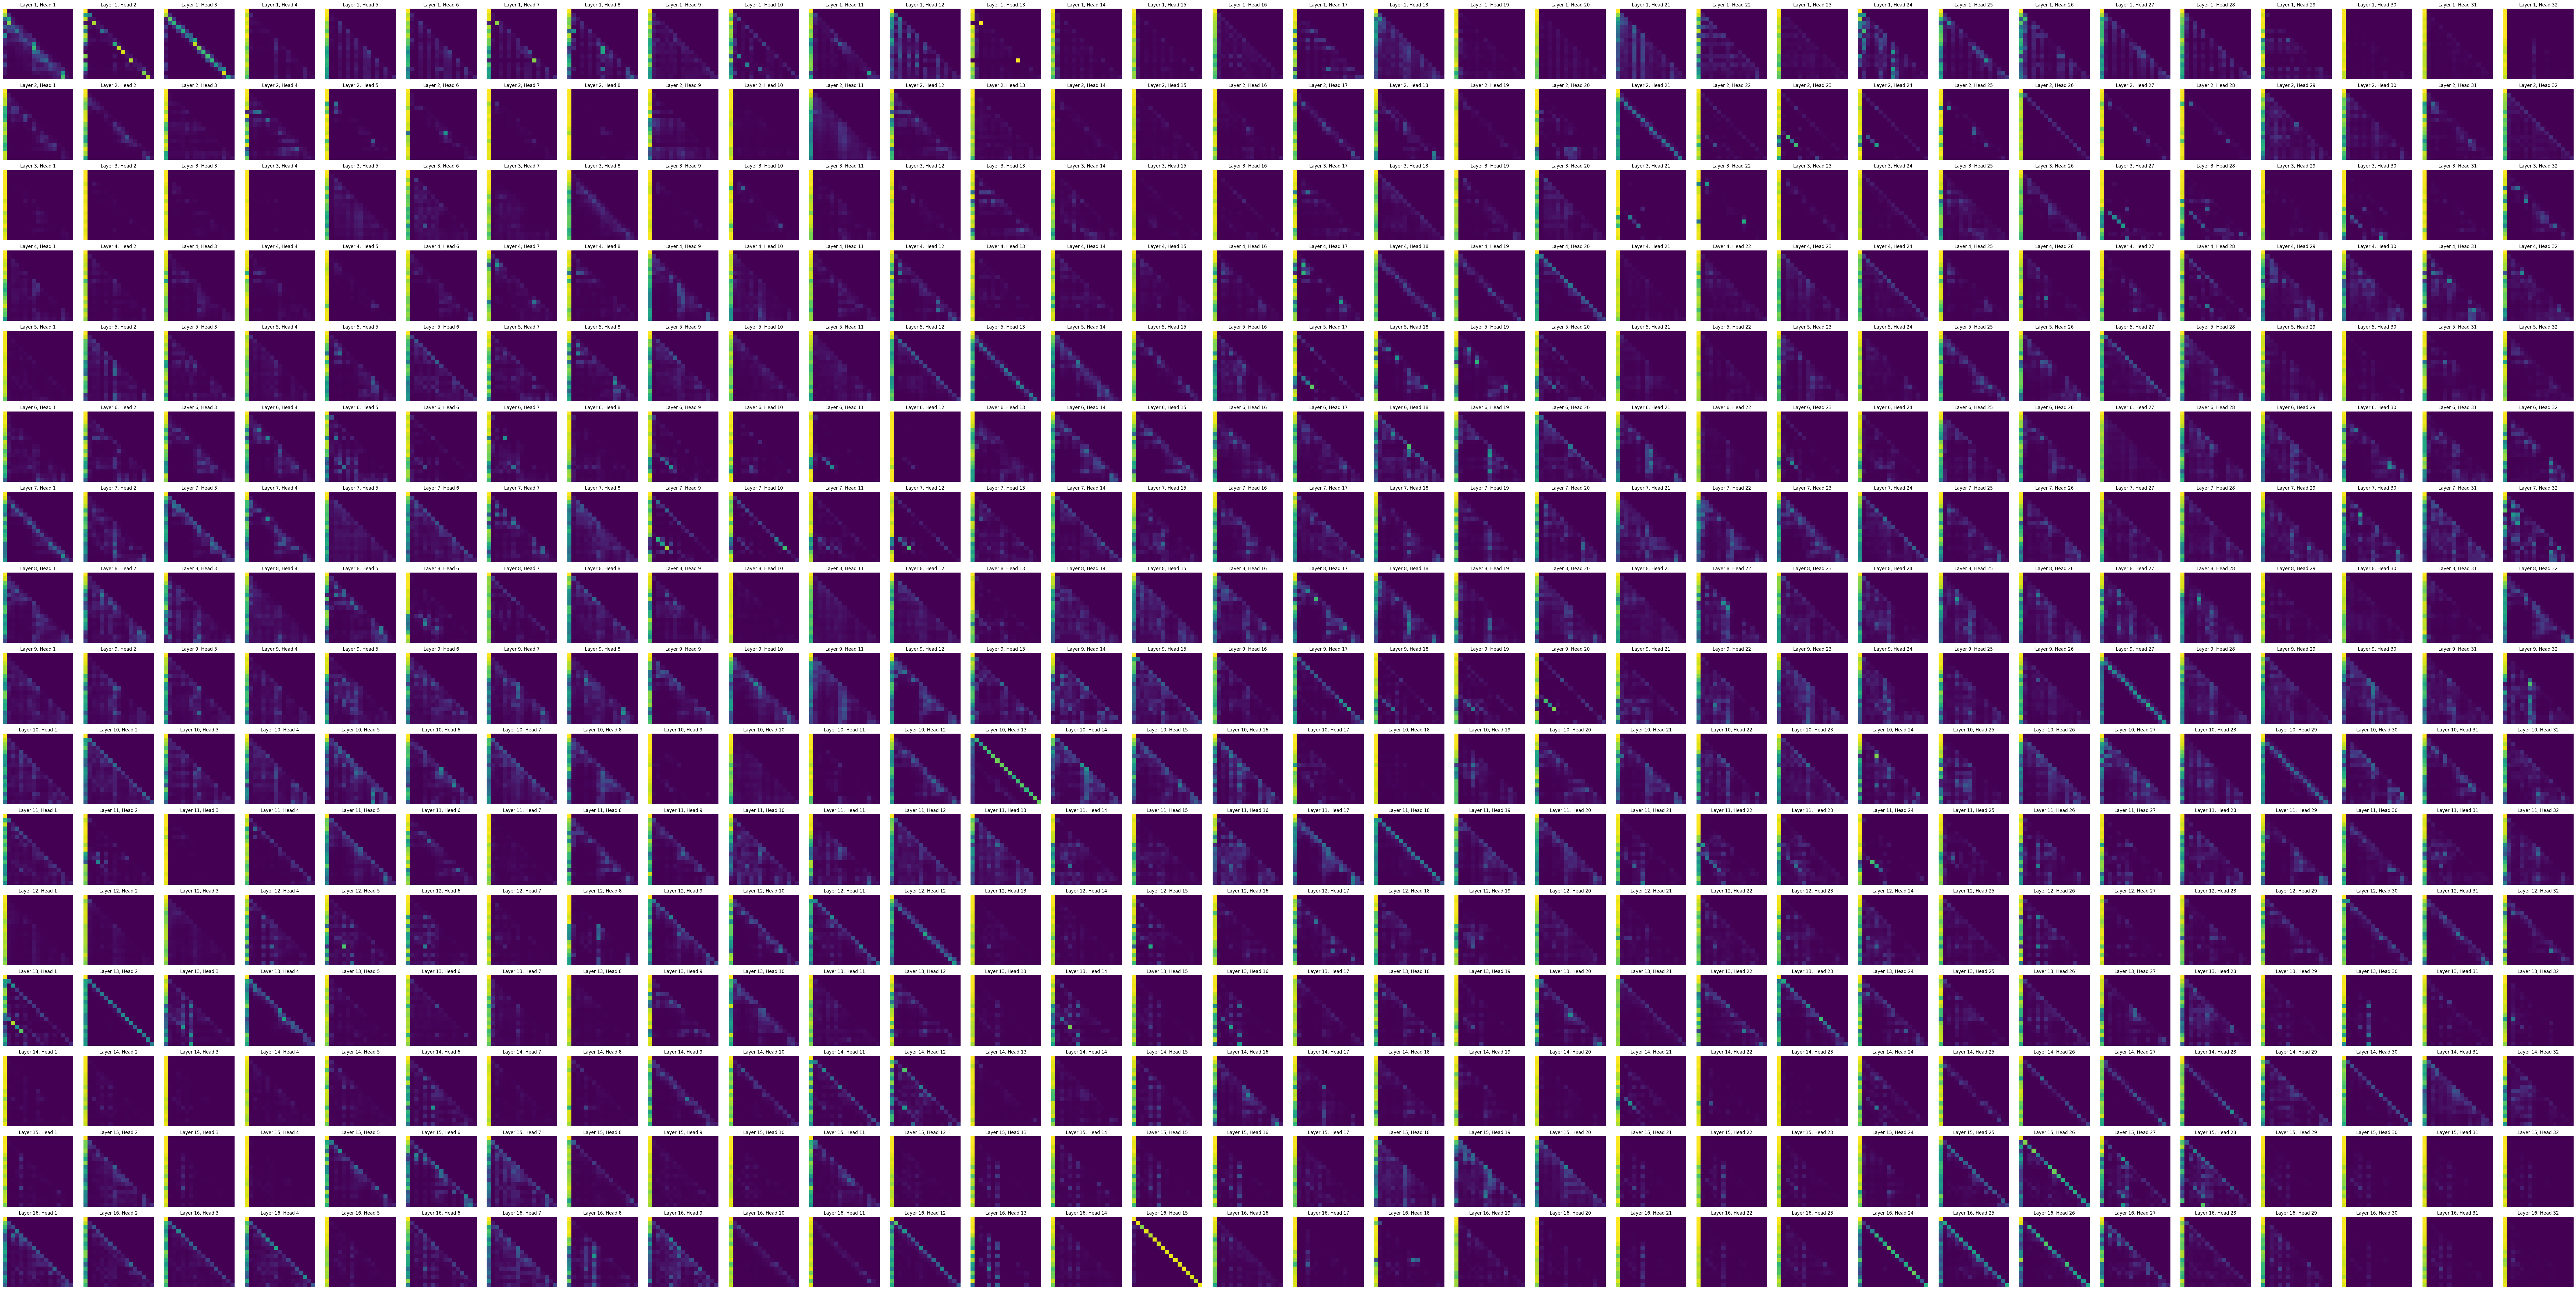

In [7]:
render_attention_maps(attens_berlin)

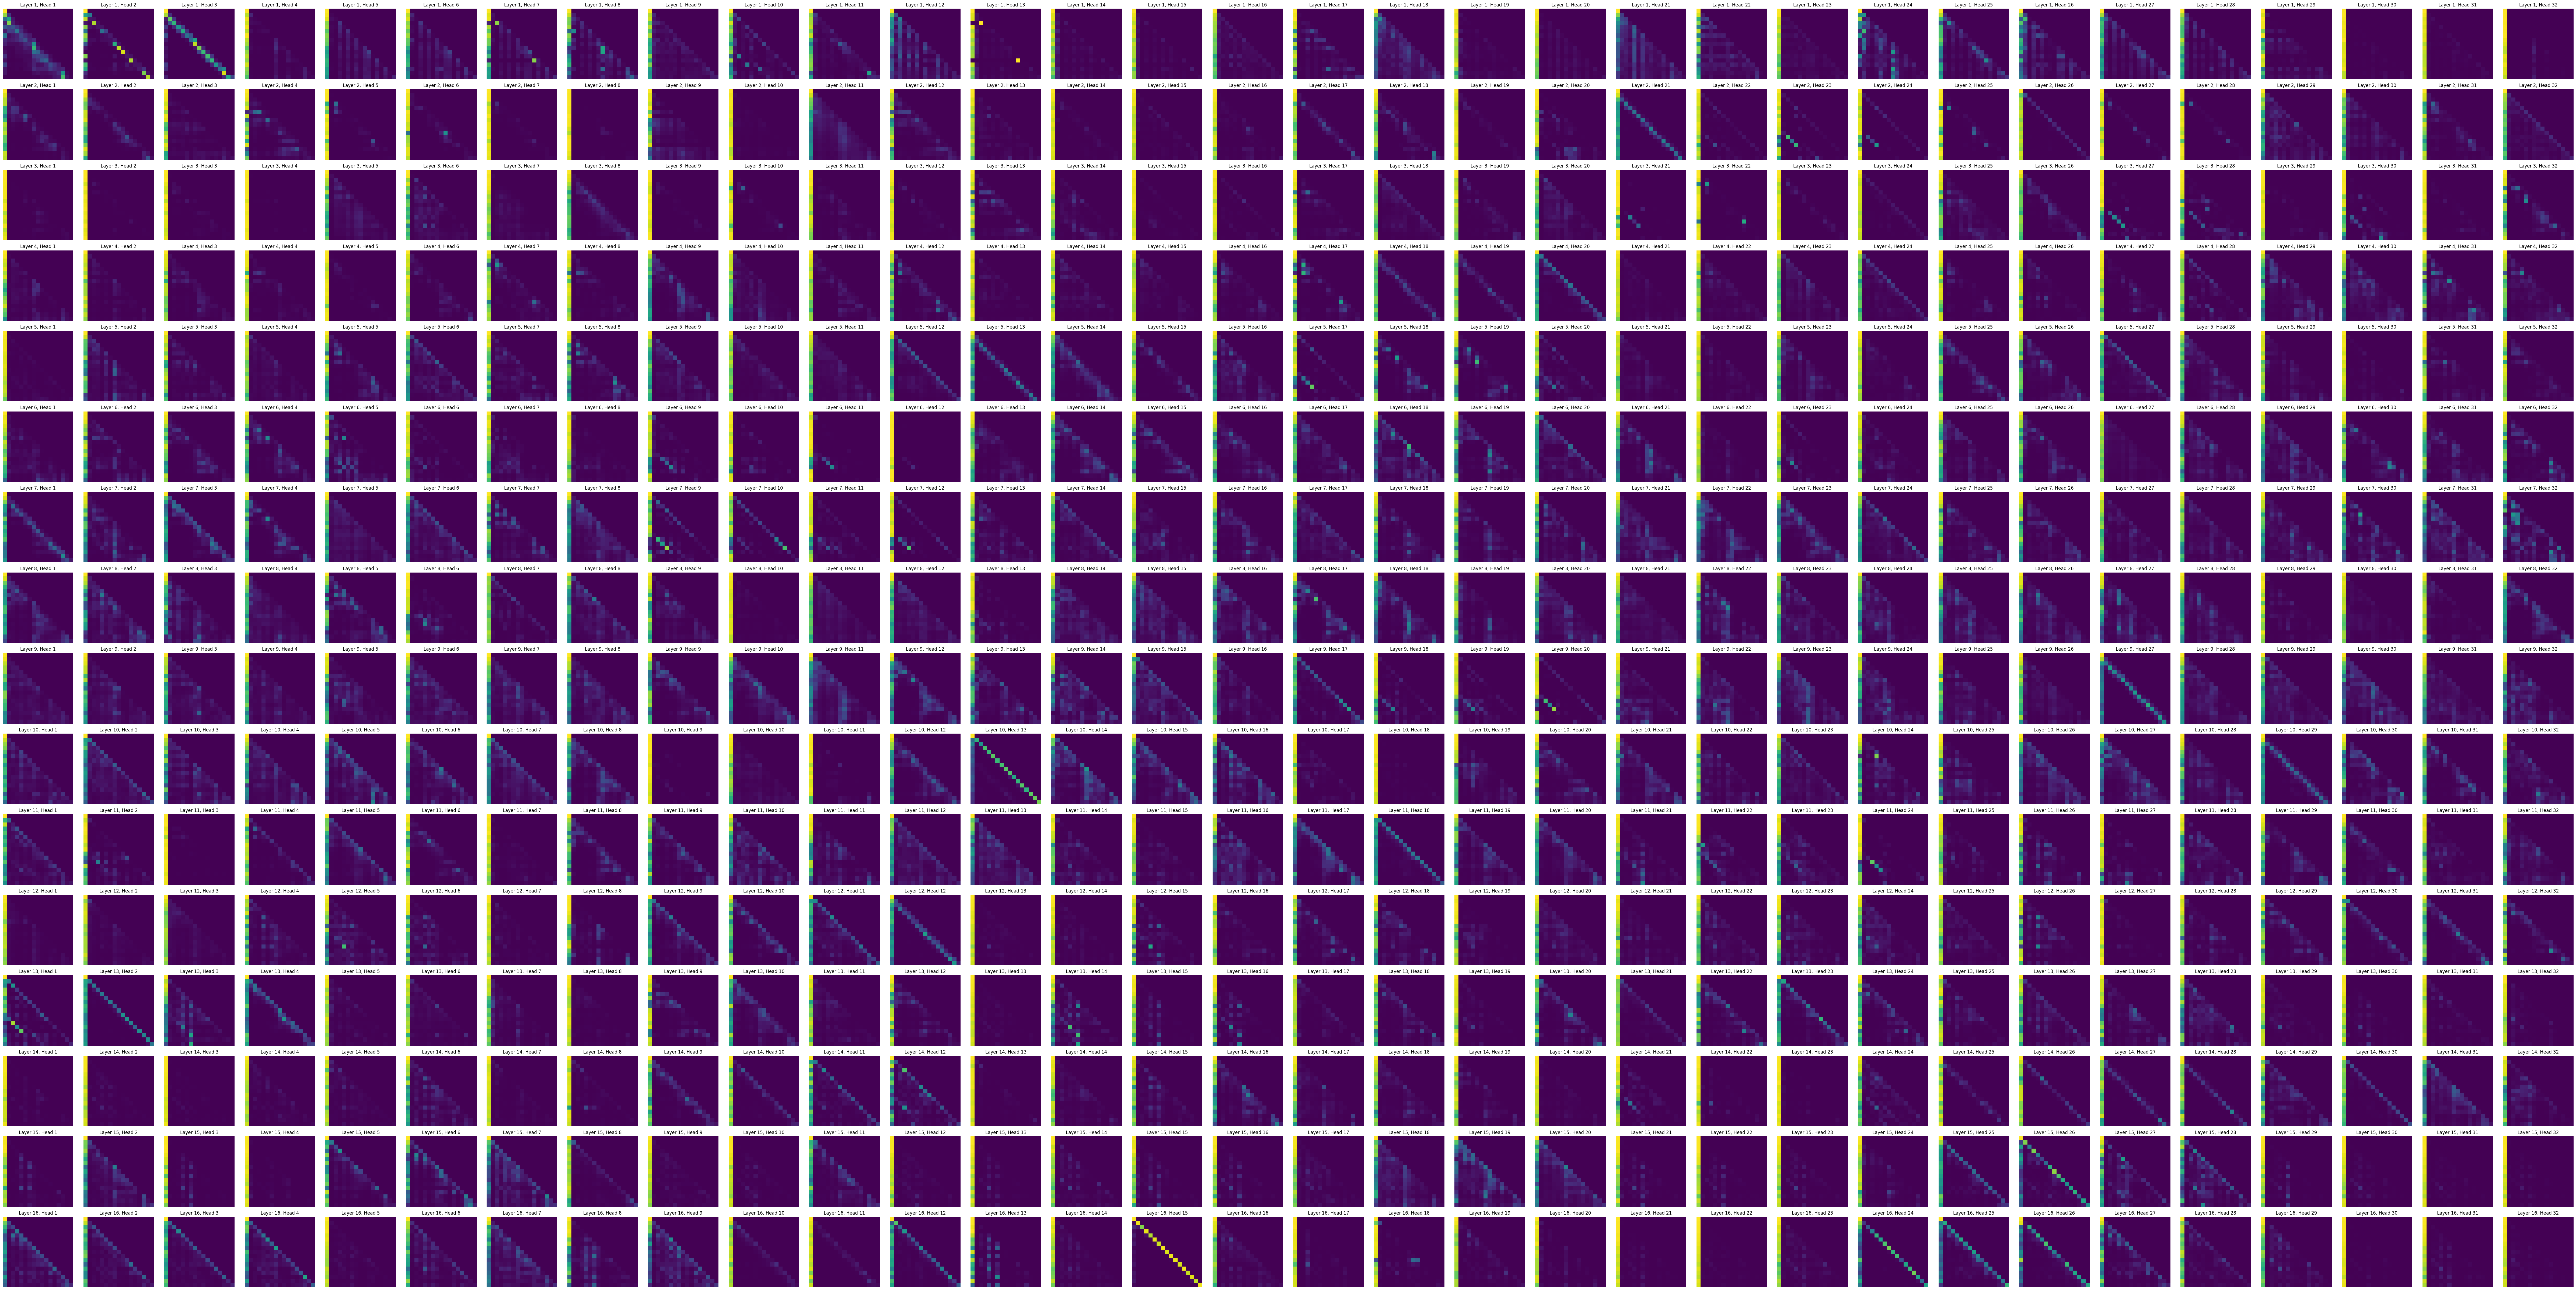

In [8]:
render_attention_maps(attens_paris)

In [9]:
attn_diff = []
for p, b in zip(attens_paris, attens_berlin):
    attn_diff.append(abs(p - b) / (b + 1e-10))

 

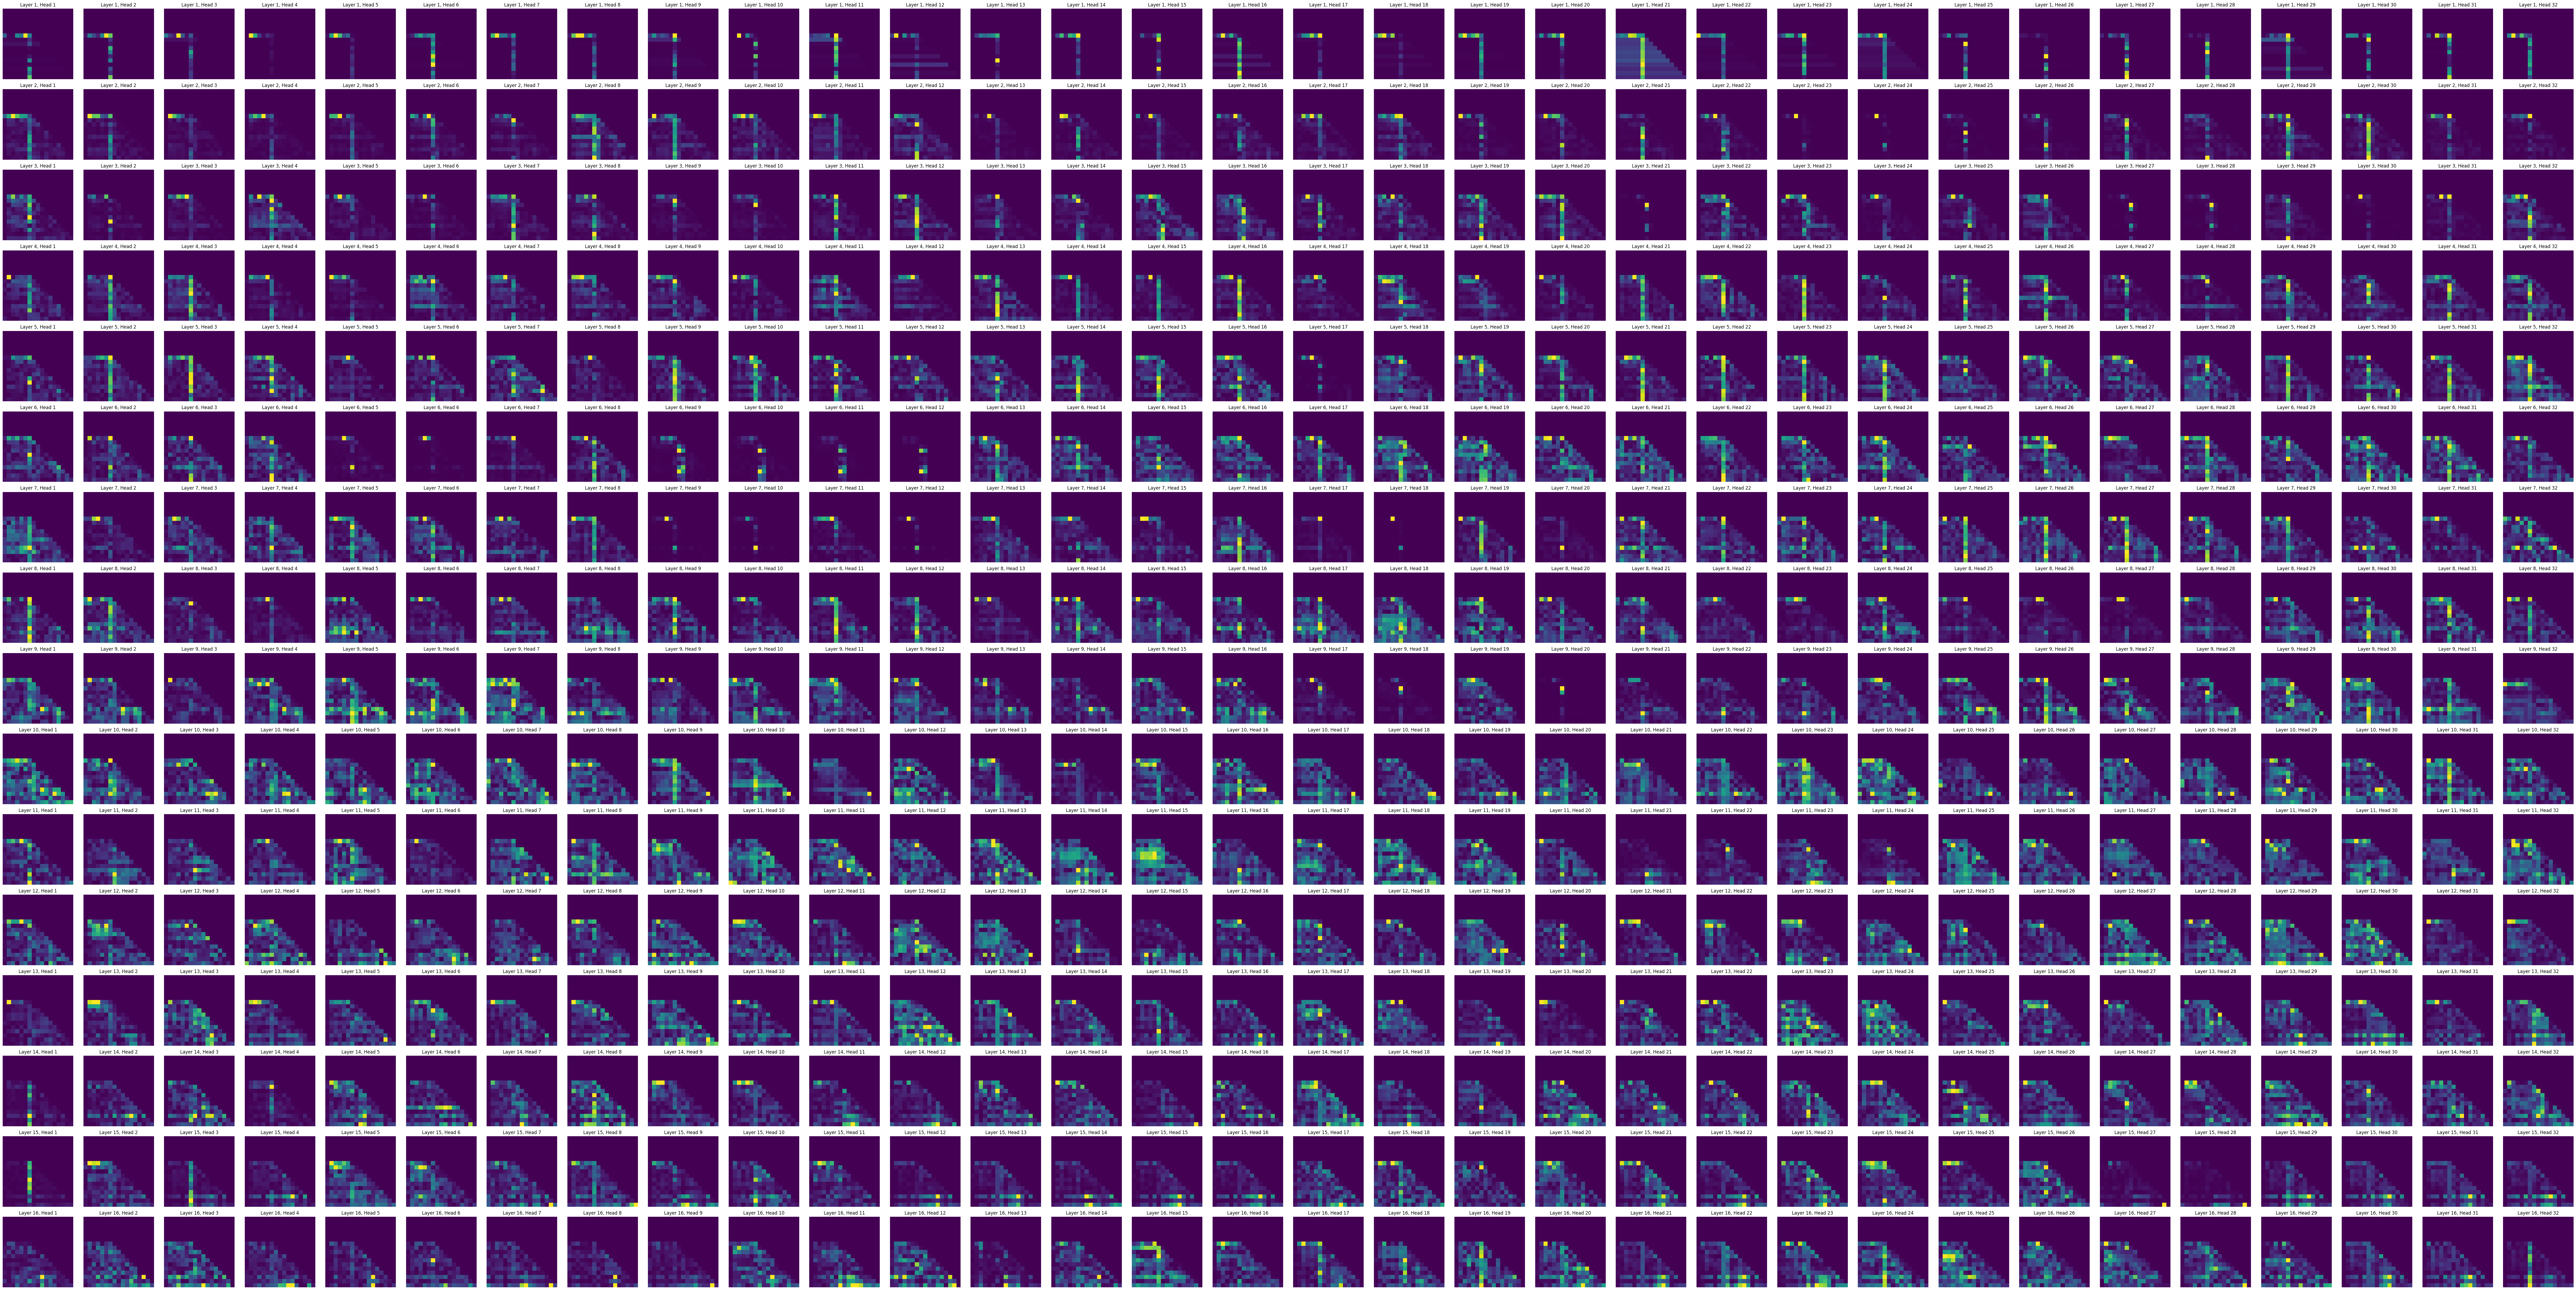

In [10]:
render_attention_maps(attn_diff)

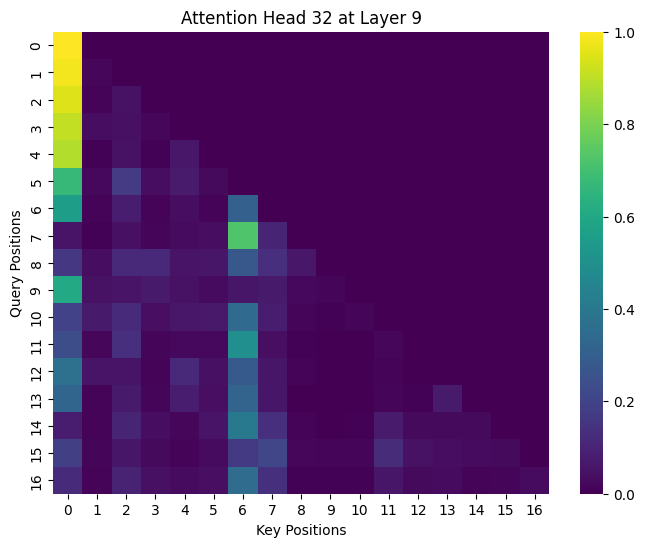

In [18]:
show_one_head(attens_berlin, 8, 31)

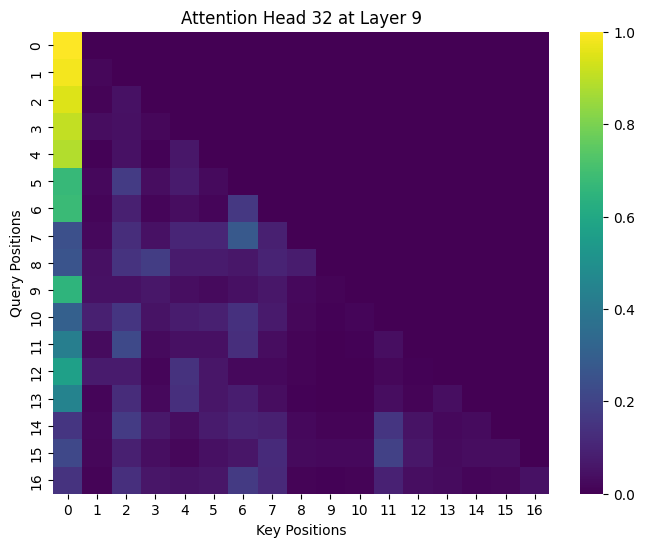

In [19]:
show_one_head(attens_paris, 8, 31)

In [3]:
PROMPT = "The capital of France is XYZ. What is the capital of France? It is"
prompt_berlin = PROMPT.replace("XYZ", "Berlin")
prompt_paris = PROMPT.replace("XYZ", "Paris")

tokens_berlin = model.tokenize(prompt_berlin)
tokens_paris = model.tokenize(prompt_paris)

In [4]:
for k in range(len(tokens_berlin['input_ids'][0])):
    print(f"Position {k}: Berlin token = {model.tokenizer.decode(tokens_berlin['input_ids'][0][k])}, Paris token = {model.tokenizer.decode(tokens_paris['input_ids'][0][k])}")

Position 0: Berlin token = <|begin_of_text|>, Paris token = <|begin_of_text|>
Position 1: Berlin token = The, Paris token = The
Position 2: Berlin token =  capital, Paris token =  capital
Position 3: Berlin token =  of, Paris token =  of
Position 4: Berlin token =  France, Paris token =  France
Position 5: Berlin token =  is, Paris token =  is
Position 6: Berlin token =  Berlin, Paris token =  Paris
Position 7: Berlin token = ., Paris token = .
Position 8: Berlin token =  What, Paris token =  What
Position 9: Berlin token =  is, Paris token =  is
Position 10: Berlin token =  the, Paris token =  the
Position 11: Berlin token =  capital, Paris token =  capital
Position 12: Berlin token =  of, Paris token =  of
Position 13: Berlin token =  France, Paris token =  France
Position 14: Berlin token = ?, Paris token = ?
Position 15: Berlin token =  It, Paris token =  It
Position 16: Berlin token =  is, Paris token =  is


In [5]:
token_berlin_list = ["The", " capital", " of", " France", " is", " Berlin", ".", " What", " is", " the", " capital", " of", " France", "?", " It", " is"]
token_paris_list = ["The", " capital", " of", " France", " is", " Paris", ".", " What", " is", " the", " capital", " of", " France", "?", " It", " is"]

In [10]:
def progress_tokens(token_list):
    prompt = ""
    for i, token_str in enumerate(token_list):
        prompt += token_str
        print(f"After adding token {i} ('{token_str}'): {prompt}")
        model.get_details(prompt)
        print("\n")

In [11]:
progress_tokens(token_berlin_list)

After adding token 0 ('The'): The
Token:  following, Probability: 0.006731679663062096
Token:  , Probability: 0.005919598042964935
Token:  first, Probability: 0.005756038706749678
Token:  main, Probability: 0.004646230023354292
Token:  best, Probability: 0.004116685129702091
----------------------------------------


After adding token 1 (' capital'): The capital
Token:  of, Probability: 0.8959503769874573
Token:  city, Probability: 0.0826796367764473
Token: ,, Probability: 0.004253420978784561
Token:  punishment, Probability: 0.0015339177334681153
Token:  is, Probability: 0.001448765047825873
----------------------------------------


After adding token 2 (' of'): The capital of
Token:  France, Probability: 0.04919769987463951
Token:  the, Probability: 0.03616860881447792
Token:  Peru, Probability: 0.03179909661412239
Token:  Australia, Probability: 0.028168249875307083
Token:  Sweden, Probability: 0.02713894098997116
----------------------------------------


After adding token 3 (' 

In [13]:
progress_tokens(token_paris_list)

After adding token 0 ('The'): The
Token:  following, Probability: 0.006731679663062096
Token:  , Probability: 0.005919598042964935
Token:  first, Probability: 0.005756038706749678
Token:  main, Probability: 0.004646230023354292
Token:  best, Probability: 0.004116685129702091
----------------------------------------


After adding token 1 (' capital'): The capital
Token:  of, Probability: 0.8959503769874573
Token:  city, Probability: 0.0826796367764473
Token: ,, Probability: 0.004253420978784561
Token:  punishment, Probability: 0.0015339177334681153
Token:  is, Probability: 0.001448765047825873
----------------------------------------


After adding token 2 (' of'): The capital of
Token:  France, Probability: 0.04919769987463951
Token:  the, Probability: 0.03616860881447792
Token:  Peru, Probability: 0.03179909661412239
Token:  Australia, Probability: 0.028168249875307083
Token:  Sweden, Probability: 0.02713894098997116
----------------------------------------


After adding token 3 (' 